# Titanic Feature Engineering

The origin notebook is [here](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/notebook)


This notebook has 3 main sections:
 - Exploratory Data Analysis
 - Feature Engineering
 - Model

## Dataset

You can download the dataset from https://www.kaggle.com/competitions/titanic

- Training set has 891 rows and test set has 418 rows
- Training set have 12 features and test set have 11 features
- One extra feature in training set is Survived feature, which is the target variable


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
train_path="../../data/titanic/train.csv"
test_path="../../data/titanic/test.csv"

In [3]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'


dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## **1. Exploratory Data Analysis**
### **1.1 Overview**
* `PassengerId` is the unique id of the row and it doesn't have any effect on target
* `Survived` is the target variable we are trying to predict (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` and `Age` are self-explanatory
* `SibSp` is the total number of the passengers' siblings and spouse
* `Parch` is the total number of the passengers' parents and children
* `Ticket` is the ticket number of the passenger
* `Fare` is the passenger fare
* `Cabin` is the cabin number of the passenger
* `Embarked` is port of embarkation and it is a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [4]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
237,238,1,2,"Collyer, Miss. Marjorie ""Lottie""",female,8.0,0,2,C.A. 31921,26.25,NaN,S
353,354,0,3,"Arnold-Franchi, Mr. Josef",male,25.0,1,0,349237,17.80,NaN,S


In [5]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
281,1173,3,"Peacock, Master. Alfred Edward",male,0.75,1,1,SOTON/O.Q. 3101315,13.775,NaN,S
239,1131,1,"Douglas, Mrs. Walter Donald (Mahala Dutton)",female,48.00,1,0,PC 17761,106.425,C86,C
38,930,3,"Sap, Mr. Julius",male,25.00,0,0,345768,9.500,NaN,S


### **1.2 Missing Values**
As seen from below, some columns have missing values. `display_missing` function shows the count of missing values in every column in both training and test set.
* Training set have missing values in `Age`, `Cabin` and `Embarked` columns
* Test set have missing values in `Age`, `Cabin` and `Fare` columns

It is convenient to work on concatenated training and test set while dealing with missing values, otherwise filled data may overfit to training or test set samples. The count of missing values in `Age`, `Embarked` and `Fare` are smaller compared to total sample, but roughly **80%** of the `Cabin` is missing. Missing values in `Age`, `Embarked` and `Fare` can be filled with descriptive statistical measures but that wouldn't work for `Cabin`.

In [6]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




#### **1.2.1 Age**

Missing values in `Age` are filled with median age, but using median age of the whole data set is not a good choice. Median age of `Pclass` groups is the best choice because of its high correlation with `Age` **(0.408106)** and `Survived` **(0.338481)**. It is also more logical to group ages by passenger classes instead of other features.

In [7]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
0,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
21,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In order to be more accurate, `Sex` feature is used as the second level of `groupby` while filling the missing `Age` values. As seen from below, `Pclass` and `Sex` groups have distinct median `Age` values. When passenger class increases, the median age for both males and females also increases. However, females tend to have slightly lower median `Age` than males. The median ages below are used for filling the missing values in `Age` feature.

In [8]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


#### **1.2.2 Embarked**
`Embarked` is a categorical feature and there are only **2** missing values in whole data set. Both of those passengers are female, upper class and they have the same ticket number. This means that they know each other and embarked from the same port together. The mode `Embarked` value for an upper class female passenger is **C (Cherbourg)**, but this doesn't necessarily mean that they embarked from that port.

In [9]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


When I googled **Stone, Mrs. George Nelson (Martha Evelyn)**, I found that she embarked from **S (Southampton)** with her maid **Amelie Icard**, in this page [Martha Evelyn Stone: Titanic Survivor](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html).

> *Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.*

Missing values in `Embarked` are filled with **S** with this information.

In [10]:
# Filling the missing values in Embarked with S
df_all['Embarked'] = df_all['Embarked'].fillna('S')

#### **1.2.3 Fare**

There is only one passenger with missing `Fare` value. We can assume that `Fare` is related to family size (`Parch` and `SibSp`) and `Pclass` features. Median `Fare` value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [23]:
df_all['Fare'].head()

0     7.2500
1    71.2833
2     7.9250
3    53.1000
4     8.0500
Name: Fare, dtype: float64

In [11]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [12]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

#### **1.2.4 Cabin**

`Cabin` feature is little tricky and it needs further exploration. The large portion of the `Cabin` feature is missing and the feature itself can't be ignored completely because some the cabins might have higher survival rates. It turns out to be the first letter of the `Cabin` values are the decks in which the cabins are located. Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.
![alt text](../../img/titanic_side_plan.png)
* On the Boat Deck there were **6** rooms labeled as **T, U, W, X, Y, Z** but only the **T** cabin is present in the dataset
* **A**, **B** and **C** decks were only for 1st class passengers
* **D** and **E** decks were for all classes
* **F** and **G** decks were for both 2nd and 3rd class passengers
* From going **A** to **G**, distance to the staircase increases which might be a factor of survival

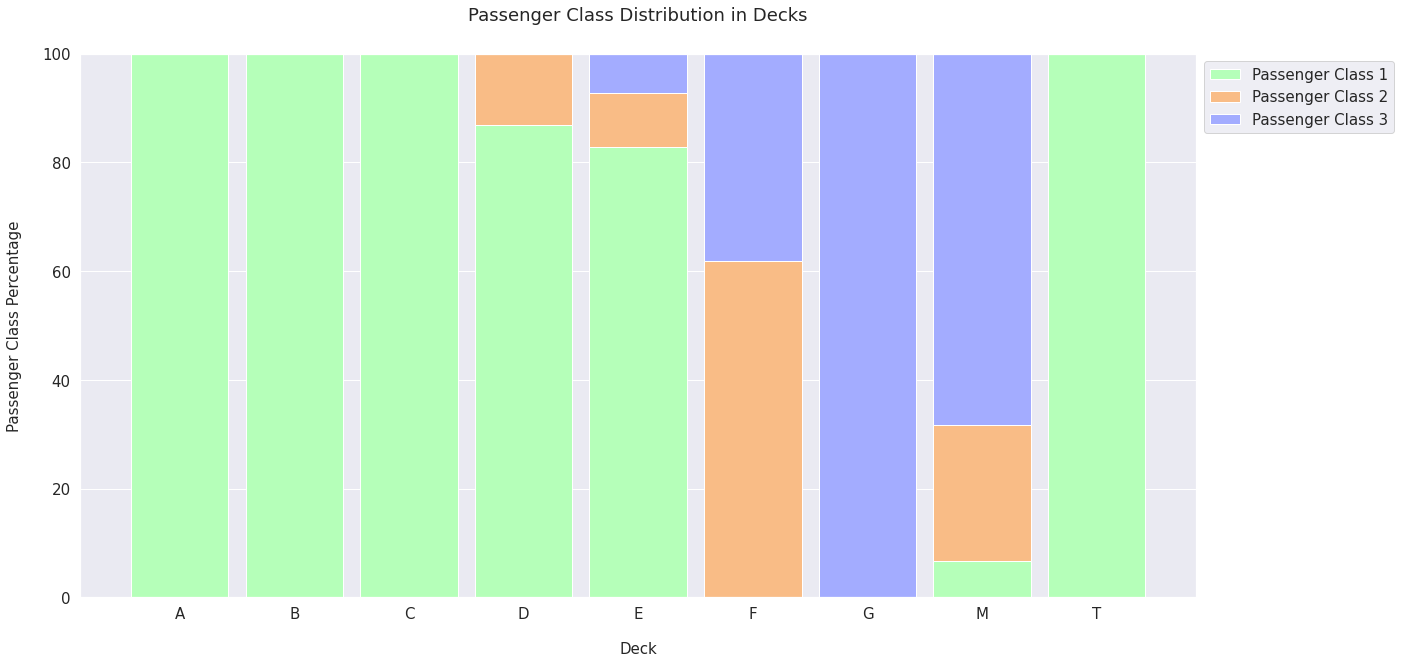

In [13]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch',
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):

    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]

    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count
            except KeyError:
                deck_counts[deck][pclass] = 0

    df_decks = pd.DataFrame(deck_counts)
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]

    return deck_counts, deck_percentages

def display_pclass_dist(percentages):

    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85

    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]

    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)

    plt.show()

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

* **100%** of **A**, **B** and **C** decks are 1st class passengers
* Deck **D** has **87%** 1st class and **13%** 2nd class passengers
* Deck **E** has **83%** 1st class, **10%** 2nd class and **7%** 3rd class passengers
* Deck **F** has **62%** 2nd class and **38%** 3rd class passengers
* **100%** of **G** deck are 3rd class passengers
* There is one person on the boat deck in **T** cabin and he is a 1st class passenger. **T** cabin passenger has the closest resemblance to **A** deck passengers so he is grouped with **A** deck
* Passengers labeled as **M** are the missing values in `Cabin` feature. I don't think it is possible to find those passengers' real `Deck` so I decided to use **M** like a deck

In [14]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

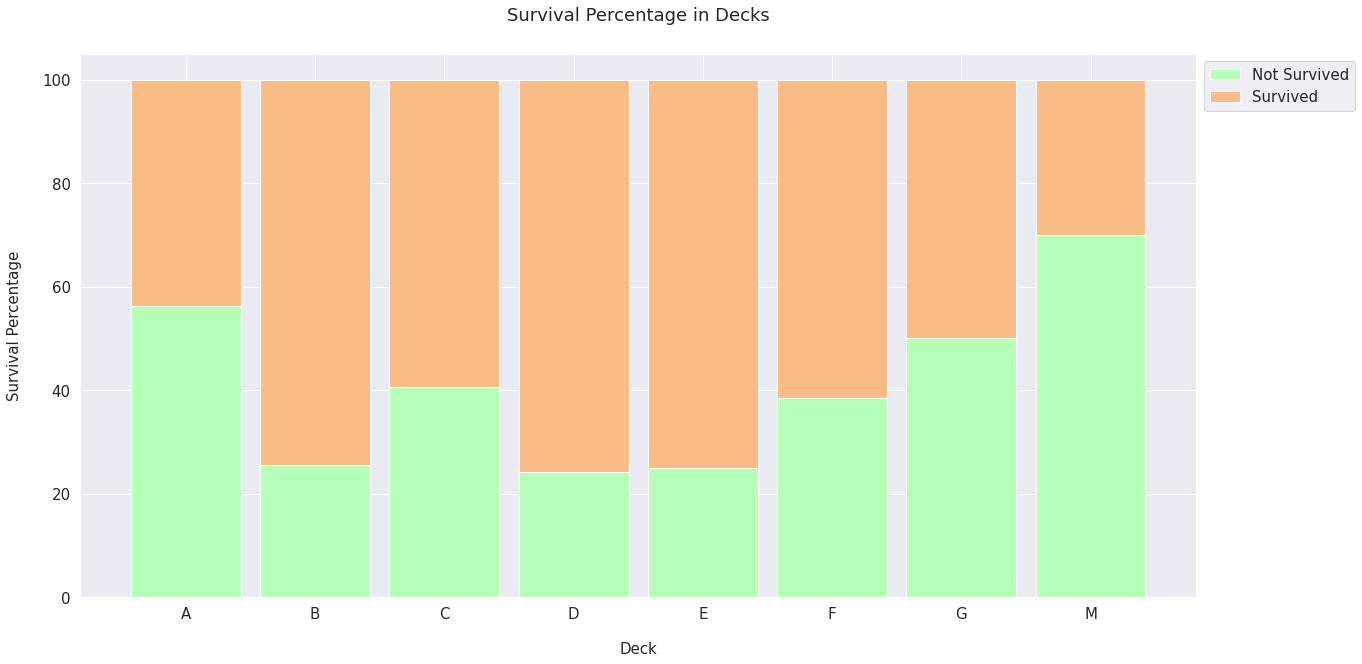

In [15]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare',
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):

    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]

    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]

    return surv_counts, surv_percentages

def display_surv_dist(percentages):

    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]

    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)

    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

As I suspected, every deck has different survival rates and that information can't be discarded. Deck **B**, **C**, **D** and **E** have the highest survival rates. Those decks are mostly occupied by 1st class passengers. **M** has the lowest survival rate which is mostly occupied by 2nd and 3rd class passengers. To conclude, cabins used by 1st class passengers have higher survival rates than cabins used by 2nd and 3rd class passengers. In my opinion **M** (Missing `Cabin` values) has the lowest survival rate because they couldn't retrieve the cabin data of the victims. That's why I believe labeling that group as **M** is a reasonable way to handle the missing data. It is a unique group with shared characteristics. `Deck` feature has high-cardinality right now so some of the values are grouped with each other based on their similarities.
* **A**, **B** and **C** decks are labeled as **ABC** because all of them have only 1st class passengers
* **D** and **E** decks are labeled as **DE** because both of them have similar passenger class distribution and same survival rate
* **F** and **G** decks are labeled as **FG** because of the same reason above
* **M** deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [16]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

After filling the missing values in `Age`, `Embarked`, `Fare` and `Deck` features, there is no missing value left in both training and test set. `Cabin` is dropped because `Deck` feature is used instead of it.

In [17]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




### **1.3 Target Distribution**
* **38.38%** (342/891) of training set is **Class 1**
* **61.62%** (549/891) of training set is **Class 0**

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


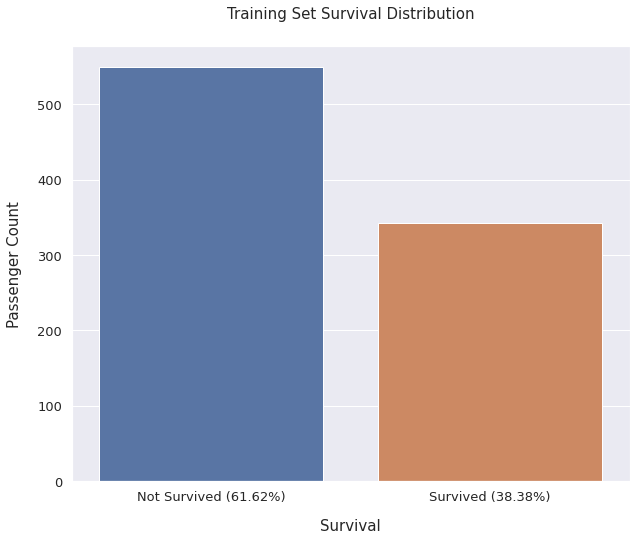

In [18]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

### **1.4 Correlations**
Features are highly correlated with each other and dependent to each other. The highest correlation between features is **0.549500** in training set and **0.577147** in test set (between `Fare` and `Pclass`). The other features are also highly correlated. There are **9** correlations in training set and **6** correlations in test set that are higher than **0.1**.

In [19]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [20]:
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.549500
8,Age,Pclass,0.417667
10,Parch,SibSp,0.414838
12,Pclass,Survived,0.338481
14,Fare,Survived,0.257307
16,Age,SibSp,0.249747
18,Parch,Fare,0.216225
20,Parch,Age,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [21]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Parch,Fare,0.230410
16,Fare,SibSp,0.172032


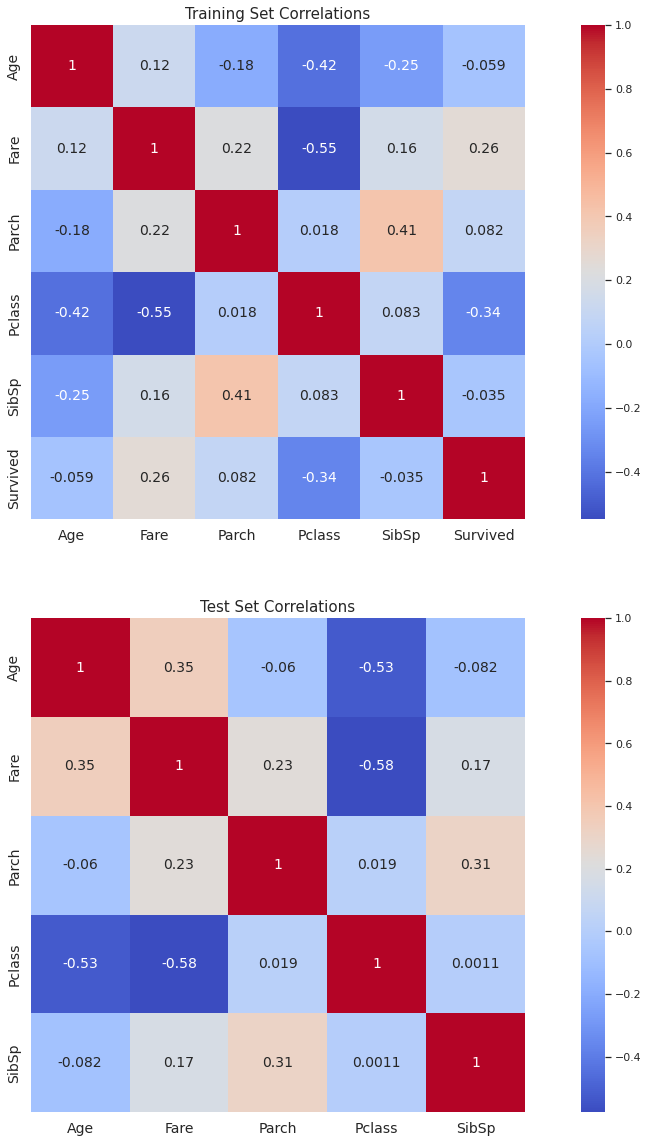

In [22]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)

axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

### **1.5 Target Distribution in Features**

#### **1.5.1 Continuous Features**
Both of the continuous features (`Age` and `Fare`) have good split points and spikes for a decision tree to learn. One potential problem for both features is, the distribution has more spikes and bumps in training set, but it is smoother in test set. Model may not be able to generalize to test set because of this reason.

* Distribution of `Age` feature clearly shows that children younger than 15 has a higher survival rate than any of the other age groups
* In distribution of `Fare` feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extremely large outliers

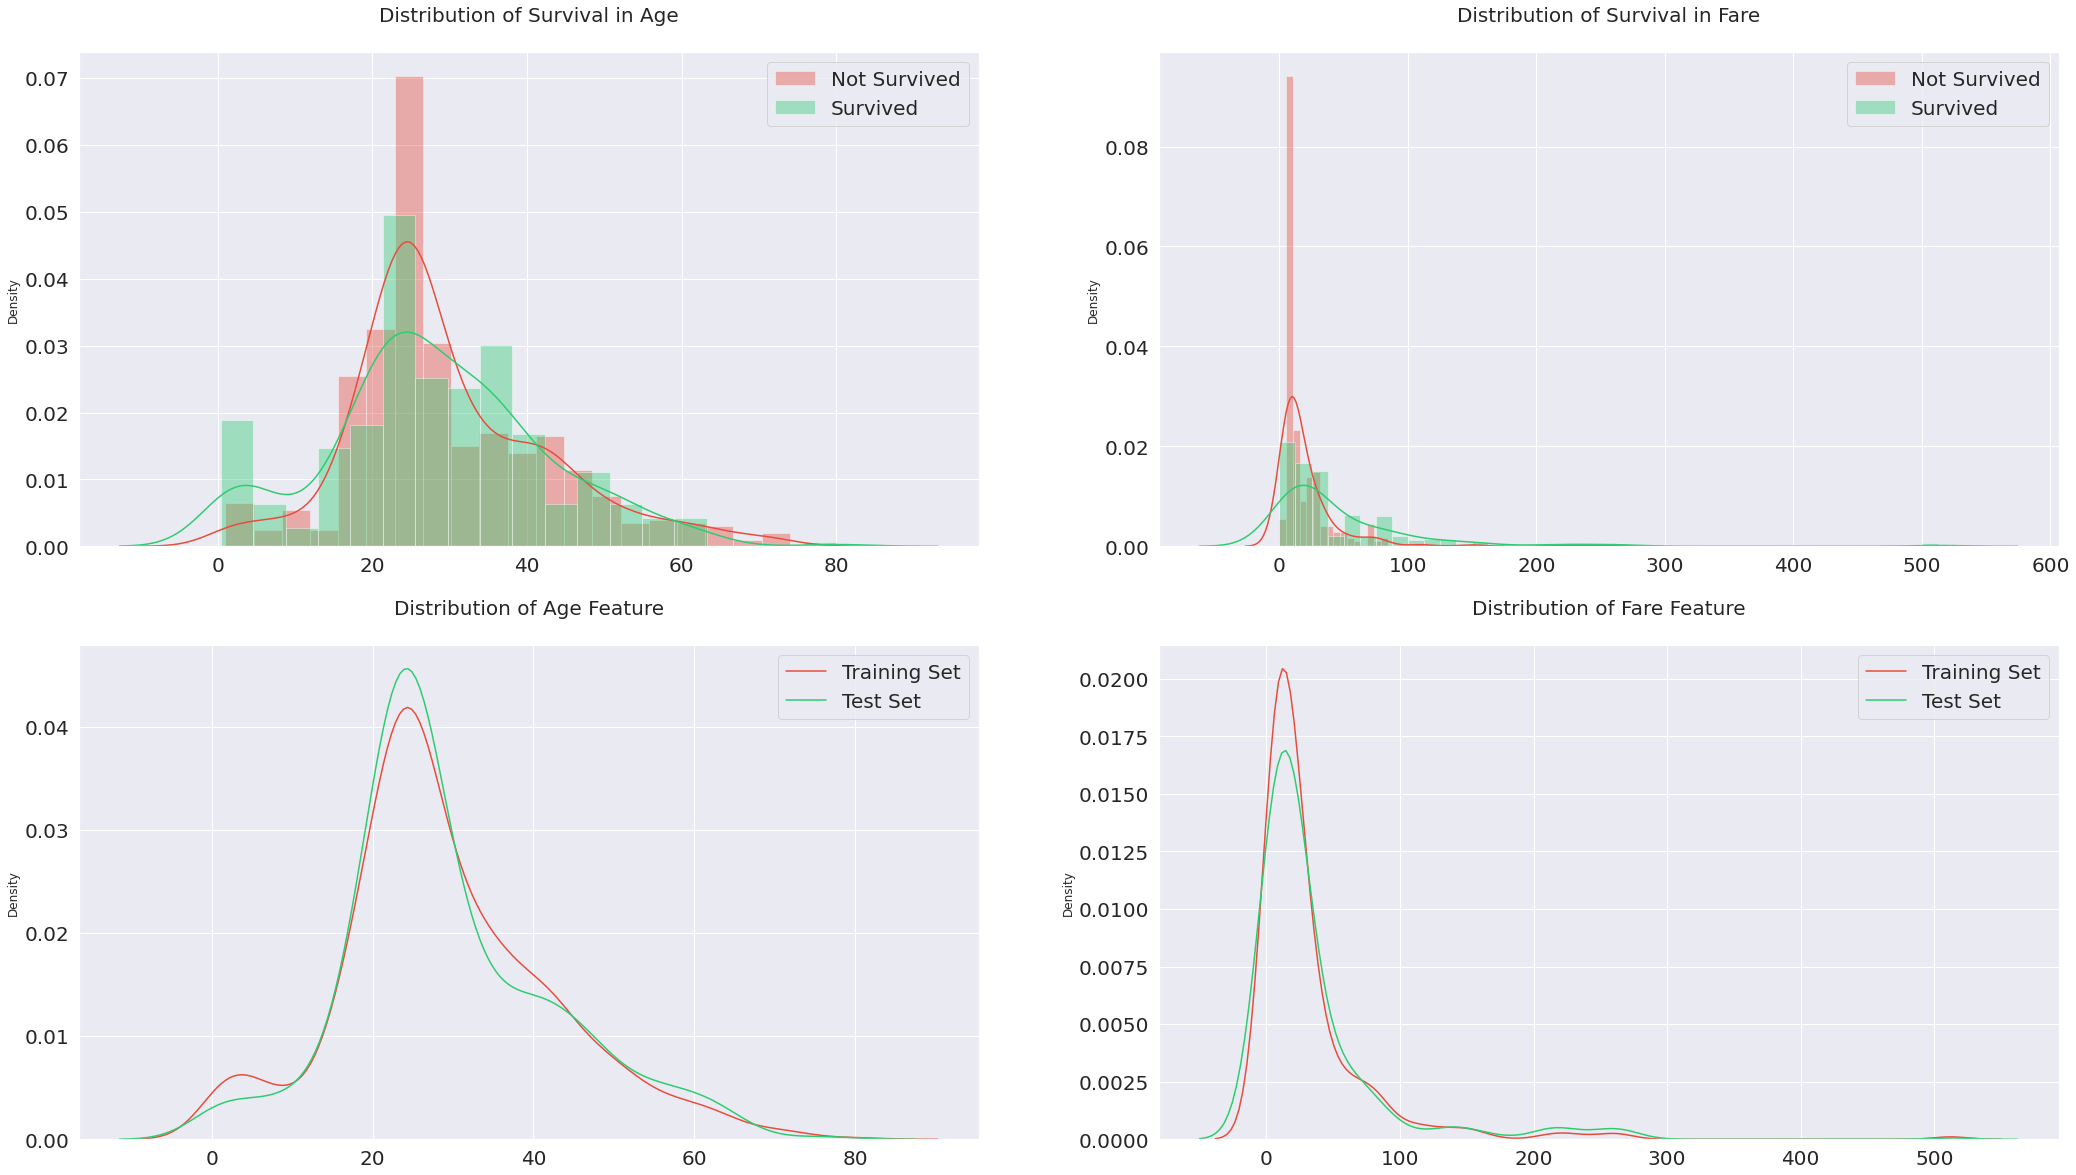

In [24]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])

    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])

    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')

    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)

    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)

plt.show()

#### **1.5.2 Categorical Features**
Every categorical feature has at least one class with high mortality rate. Those classes are very helpful to predict whether the passenger is a survivor or victim. Best categorical features are `Pclass` and `Sex` because they have the most homogenous distributions.

* Passengers boarded from **Southampton** has a lower survival rate unlike other ports. More than half of the passengers boarded from **Cherbourg** had survived. This observation could be related to `Pclass` feature
* `Parch` and `SibSp` features show that passengers with only one family member has a higher survival rate

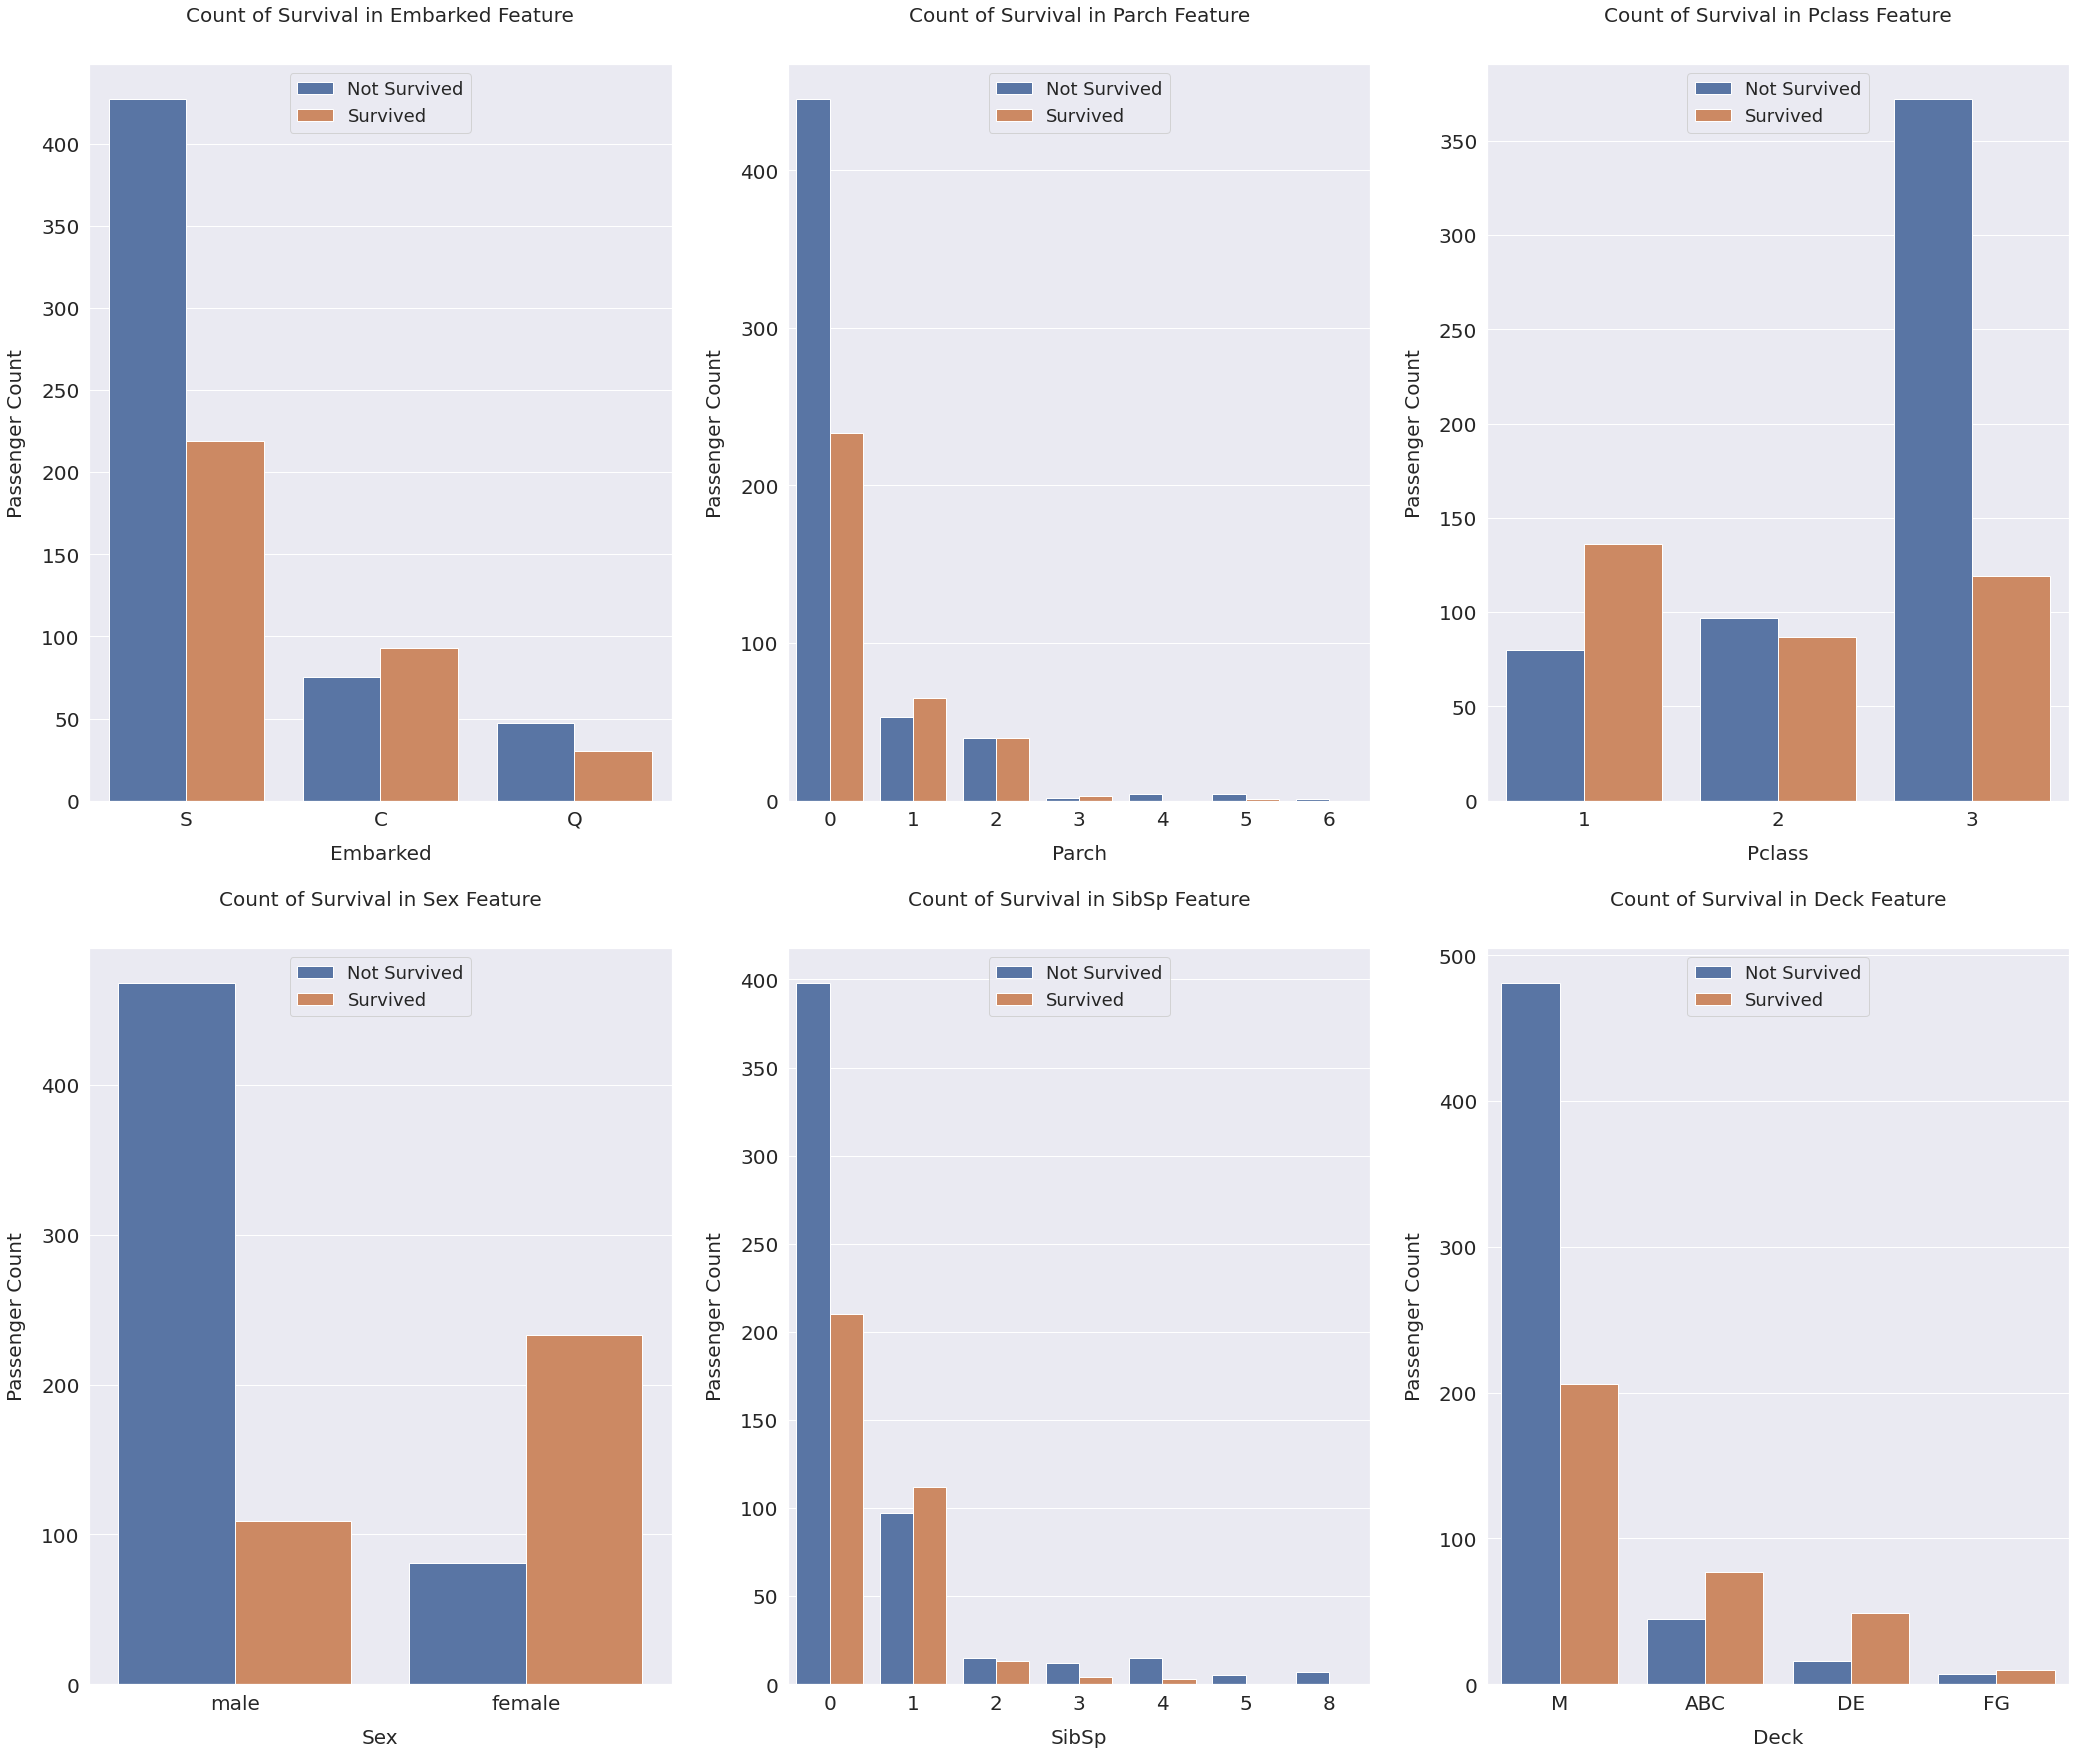

In [25]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)

    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)

    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

### **1.6 Conclusion**
Most of the features are correlated with each other. This relationship can be used to create new features with feature transformation and feature interaction. Target encoding could be very useful as well because of the high correlations with `Survived` feature.

Split points and spikes are visible in continuous features. They can be captured easily with a decision tree model, but linear models may not be able to spot them.

Categorical features have very distinct distributions with different survival rates. Those features can be one-hot encoded. Some of those features may be combined with each other to make new features.

Created a new feature called `Deck` and dropped `Cabin` feature at the **Exploratory Data Analysis** part.

In [ ]:
df_all = concat_df(df_train, df_test)
df_all.head()

## **2. Feature Engineering**

### **2.1 Binning Continuous Features**
